In [1]:
#引入库
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS']
matplotlib.rcParams['axes.unicode_minus']=False

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.rcParams['font.sans-serif']=['simhei']
plt.rcParams['font.serif'] = ['simhei']

import warnings
warnings.filterwarnings('ignore')
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\SimHei.ttf',size=12)
sns.set(font=myfont.get_name())

In [2]:
#数据读取，并打印前4行
df = pd.read_csv('信息加工维度.csv')

In [3]:
#数据处理：缺失值检查,false即表示无缺失值,若对行处理则令axis=1
print(df.isnull().any())

personid           False
score              False
time_before_ddl    False
dtype: bool


In [4]:
#数据处理：去除重复值,使用drop_duplicates函数，输出为重复值数
df.duplicated().sum()

0

In [5]:
#基于pyspark的数据统计分析，此处仅使用描述分析与频率统计
#mean()函数或describe()函数对均值进行描述统计.T表示矩阵逆置，行输出
df.describe().T

,count,mean,std,min,25%,50%,75%,max
personid,243.0000,129480950.0700,25868008.7015,51455892.0000,111945908.0000,111948913.0000,147388816.5000,197263536.0000
score,243.0000,48.7458,23.7102,0.0300,41.8750,51.5600,59.6750,92.7200
time_before_ddl,243.0000,13.1614,23.7146,0.1100,1.9800,4.8400,13.0650,114.8700


In [6]:
#rename，更改列名以方便可视化展现
df.rename(columns={'personid':'学生编号','score':'分数','time_before_ddl':'提前提交作业时间'},inplace=True)
df

,学生编号,分数,提前提交作业时间
0,51455892,59.9000,7.5200
1,51466294,70.6100,0.8100
2,67695313,75.1600,1.4600
3,67697725,78.5400,1.6000
4,68286748,47.9200,18.2300
...,...,...,...
238,197259586,88.8800,108.8300
239,197259971,90.8600,114.8700
240,197261324,90.1600,77.0400
241,197261517,92.2100,109.1000


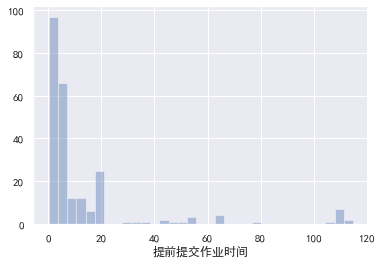

In [7]:
sns.distplot(df["提前提交作业时间"],kde=False)
plt.show()

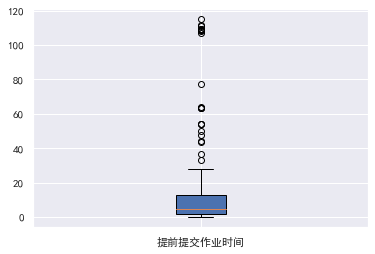

In [8]:
d1 = df['提前提交作业时间']
# 横坐标，显示均值
plt.boxplot(d1,patch_artist=True,labels=['提前提交作业时间'])
plt.show()

In [9]:
# 箱型图判断异常点
def box_outlier(data):
    df = data.copy(deep=True)
    out_index = []
    for col in df.columns:             # 对每一列分别用箱型图进行判断
        Q1 = df[col].quantile(q=0.25)       # 下四分位
        Q3 = df[col].quantile(q=0.75)       # 上四分位
        low_whisker = Q1 - 1.5 * (Q3 - Q1)  # 下边缘
        up_whisker = Q3 + 1.5 * (Q3 - Q1)   # 上边缘
        
        # 寻找异常点,获得异常点索引值，删除索引值所在行数据
        rule = (df[col] > up_whisker) | (df[col] < low_whisker)  
        out = df[col].index[rule]
        out_index += out.tolist()  
    df.drop(out_index, inplace=True)
    return df

df_clean = box_outlier(df)
df_clean

,学生编号,分数,提前提交作业时间
2,67695313,75.1600,1.4600
3,67697725,78.5400,1.6000
4,68286748,47.9200,18.2300
5,73095160,39.4500,0.7200
6,98289131,77.1600,3.9600
...,...,...,...
224,147393726,54.4600,4.9600
225,147393731,51.4900,0.1100
226,147393768,52.8900,4.8800
227,147393863,24.8200,1.7200


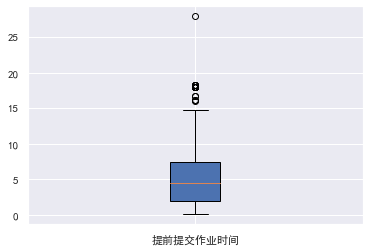

In [10]:
d1_clean = df_clean['提前提交作业时间']
# 横坐标，显示均值
plt.boxplot(d1_clean,patch_artist=True,labels=['提前提交作业时间'])
plt.show()

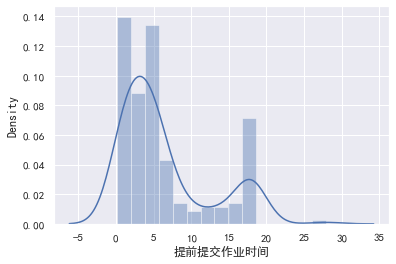

In [11]:
# 单变量分布直方图
# kde核密度走势图，rug胡须下线，线越多表示数量越密
sns.distplot(df_clean["提前提交作业时间"],kde = True,label = '频率')
plt.show()

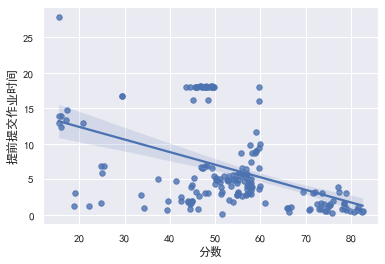

In [12]:
# 线性回归关系图
sns.regplot(x='分数',y='提前提交作业时间',data=df_clean,scatter_kws={'marker':'.','s':30},line_kws={'color':'b'})

In [17]:
# 将col列按照前50%和后50%拆分成before和after两个DataFrame
col_sorted = df_clean.sort_values(by='提前提交作业时间')
col_split_idx = int(col_sorted.shape[0] / 2)
before_df = col_sorted.iloc[:col_split_idx]
after_df = col_sorted.iloc[col_split_idx:]

# 输出before和after的x和y到txt文件
with open('output.txt','w') as f:
    # 输出before型
    before_x = before_df['提前提交作业时间'].tolist()
    before_y = before_df['分数'].tolist()
    before_json = {
        "dimensions": ["沉思型"],
        "source": [[x, y] for x, y in zip(before_x, before_y)]
    }
    f.write(str(before_json) + '\n')

    # 输出after型
    after_x = after_df['提前提交作业时间'].tolist()
    after_y = after_df['分数'].tolist()
    after_json = {
        "dimensions": ["活跃型"],
        "source": [[x, y] for x, y in zip(after_x, after_y)]
    }
    f.write(str(after_json) + '\n')
